In [1]:
from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})

{'CodeCell': {'cm_config': {'autoCloseBrackets': False}},
 'load_extensions': {'nbextensions_configurator/config_menu/main': True,
  'contrib_nbextensions_help_item/main': True,
  'hinterland/hinterland': True,
  'toc2/main': True},
 'toc2': {'skip_h1_title': True,
  'toc_cell': True,
  'title_cell': 'Содержание',
  'toc_window_display': True}}

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Обработка" data-toc-modified-id="Обработка-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Обработка</a></span><ul class="toc-item"><li><span><a href="#Очистка-текста-и-лемматизация" data-toc-modified-id="Очистка-текста-и-лемматизация-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Очистка текста и лемматизация</a></span></li></ul></li><li><span><a href="#Длина" data-toc-modified-id="Длина-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Длина</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Улучшение-логистической-регрессии-древом-решений." data-toc-modified-id="Улучшение-логистической-регрессии-древом-решений.-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Улучшение логистической регрессии древом решений.</a></span></li><li><span><a href="#Глупая-модель" data-toc-modified-id="Глупая-модель-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Глупая модель</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [56]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit, cross_val_predict
from sklearn.metrics import f1_score
import re
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
#from sklearn.preprocessing import StandardScaler
import nltk
#import pickle
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from catboost import CatBoostClassifier
from scipy.sparse import vstack
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn import tree

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\segey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\segey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\segey\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Подготовка

### Загрузка данных

In [3]:
data = pd.read_csv('datasets/toxic_comments.csv').drop_duplicates().reset_index(drop=True)
data

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


In [4]:
data['toxic'].sum()/len(data)

0.10167887648758234

В выборке только 10% комментариев считаются токсичными.

### Обработка

#### Очистка текста и лемматизация

Удалим все ссылки, оставим только текст, убираем лишние пробелы, одиночные символы, переводим в нижний регистр, после чего лемматизируем:

In [5]:
stemmer = WordNetLemmatizer()

In [6]:
def text_cleaner(text):
    text = re.sub('https?:\/\/.*[\r\n]*', ' ', text)
    
    text = re.sub(r'\'m', ' am', text)
    text = re.sub(r'\'re', ' are', text)
    text = re.sub(r'n\'t', ' not', text)
    
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    
    text = re.sub('I ','placeiplace ', text)
    
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    text = re.sub('placeiplace ', 'I ', text)
    
    text = text.lower()
    
    text = text.split()
    text = [stemmer.lemmatize(word) for word in text]
    text = ' '.join(text)
    
    return text

In [7]:
data['text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [8]:
text_cleaner(data['text'][0])

'explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalism just closure on some gas after i voted at new york doll fac and please do not remove the template from the talk page since i am retired now'

In [9]:
data['text'] = data['text'].apply(text_cleaner)
data.head()

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he match this background colour i am see...,0
2,hey man i am really not trying to edit war it ...,0
3,more i ca not make any real suggestion on impr...,0
4,you sir are my hero any chance you remember wh...,0


### Длина

Возможно, что между токсичностью и длиной есть корреляция.

In [10]:
def find_length(x):
    n = re.split('\s|\n',x)
    return len(n)

In [11]:
data['length'] = data['text'].apply(find_length)

toxic
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: length, dtype: object

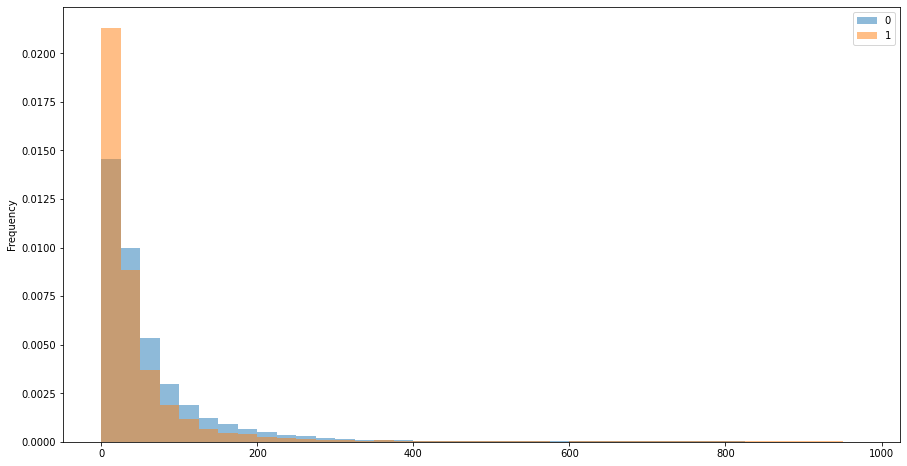

In [12]:
data.groupby('toxic')['length'].plot.hist(figsize = (15,8), legend=True, bins = [x*25 for x in range(40)], density = True,alpha = 0.5)

Короткие сообщения чаще бывают токсичными, но с длинными ситуация перерастает в противоположную, при этом большинство сообщений короткие. Эту инофрмацию можно будет использовать, если потребуется улучшать модель.

## Обучение

In [13]:
stopwords = set(nltk_stopwords.words('english'))
tf_idf = TfidfVectorizer(stop_words=stopwords)

In [14]:
features_train, features_test, target_train, target_test = train_test_split(data['text'],
                                                                            data['toxic'],
                                                                            test_size = 0.4,
                                                                            random_state=13,
                                                                            stratify=data['toxic'])

features_valid, features_test, target_valid, target_test = train_test_split(features_test,
                                                                            target_test,
                                                                            test_size = 0.5,
                                                                            random_state=13,
                                                                            stratify=target_test)

In [15]:
features_train_full = pd.concat([features_train,features_valid])
target_train_full = pd.concat([target_train,target_valid])

In [16]:
train_full_index = features_train_full.index
test_index = target_test.index

In [17]:
features_train_full = tf_idf.fit_transform(features_train_full.values)
features_test_full = tf_idf.transform(features_test.values)

In [18]:
features_train = tf_idf.fit_transform(features_train.values)
features_valid = tf_idf.transform(features_valid.values)
features_test = tf_idf.transform(features_test.values)

### Логистическая регрессия

In [19]:
feat_length = features_train.shape[0]
valid_length = features_valid.shape[0]

In [20]:
features_trainx = vstack((features_train,features_valid))

In [21]:
train_indices = np.full((feat_length,), -1, dtype=int)
valid_indices = np.full((valid_length,), 0, dtype=int)
valid_fold = np.append(train_indices, valid_indices)

In [22]:
ps = PredefinedSplit(valid_fold)

<div class="alert alert-block alert-info">
<b>Совет: </b> Приводить тексты к юникоду не имеет смысла, так как они все на английском.
</div>

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что векторизатор был обучен только на тренировочной части данных. Это умнеьшает переобучение.
</div>

In [23]:
model = LogisticRegression()

In [24]:
%%time
parameters = {'class_weight': [None],
              'penalty': ['l1','l2','elasticnet'],
              'C': [1.0,1.2,1.4],
             'random_state': [13],
             'solver': ['saga'],
             'max_iter': [200]
             }

log_model = GridSearchCV(model, param_grid=parameters, scoring='f1',cv = ps, verbose=2, refit=0)

log_model.fit(features_trainx, target_train_full)

params = log_model.best_params_
params

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END C=1.0, class_weight=None, max_iter=200, penalty=l1, random_state=13, solver=saga; total time=  26.8s
[CV] END C=1.0, class_weight=None, max_iter=200, penalty=l2, random_state=13, solver=saga; total time=   1.6s
[CV] END C=1.0, class_weight=None, max_iter=200, penalty=elasticnet, random_state=13, solver=saga; total time=   0.0s
[CV] END C=1.2, class_weight=None, max_iter=200, penalty=l1, random_state=13, solver=saga; total time=  30.1s
[CV] END C=1.2, class_weight=None, max_iter=200, penalty=l2, random_state=13, solver=saga; total time=   1.7s
[CV] END C=1.2, class_weight=None, max_iter=200, penalty=elasticnet, random_state=13, solver=saga; total time=   0.0s
[CV] END C=1.4, class_weight=None, max_iter=200, penalty=l1, random_state=13, solver=saga; total time=  42.7s
[CV] END C=1.4, class_weight=None, max_iter=200, penalty=l2, random_state=13, solver=saga; total time=   1.6s
[CV] END C=1.4, class_weight=None, max_iter=2

p:\program files\python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 9.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "p:\program files\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "p:\program files\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1471, in fit
    raise ValueError(
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn(some_fits_failed_message, FitFailedWarning)
p:\program files\python39\lib\site-packages\sklearn\mode

{'C': 1.4,
 'class_weight': None,
 'max_iter': 200,
 'penalty': 'l1',
 'random_state': 13,
 'solver': 'saga'}

In [25]:
log_model.best_score_

0.7714384508990318

Проверим на тестовой:

In [26]:
log_best = LogisticRegression(**params)
log_best.fit(features_train_full,target_train_full)

LogisticRegression(C=1.4, max_iter=200, penalty='l1', random_state=13,
                   solver='saga')

In [27]:
prediction = log_best.predict(features_test_full)

In [28]:
f1_score(target_test,prediction)

0.7823234938719144

Логистическая регрессия дала очень хороший результат.

In [29]:
test_proba = log_best.predict_proba(features_test_full)

### CatBoost

In [30]:
parameters = {'iterations': 500,
             'random_seed': 42,
             #'task_type': 'GPU',
             }

In [31]:
catmodel = CatBoostClassifier(**parameters)

In [32]:
%%time

catmodel.fit(features_train,target_train,eval_set=(features_valid,target_valid))

Learning rate set to 0.132187
0:	learn: 0.5618747	test: 0.5617261	best: 0.5617261 (0)	total: 906ms	remaining: 7m 32s
1:	learn: 0.4727648	test: 0.4720670	best: 0.4720670 (1)	total: 1.55s	remaining: 6m 25s
2:	learn: 0.4071915	test: 0.4066672	best: 0.4066672 (2)	total: 2.15s	remaining: 5m 56s
3:	learn: 0.3608898	test: 0.3604348	best: 0.3604348 (3)	total: 2.78s	remaining: 5m 44s
4:	learn: 0.3263376	test: 0.3260147	best: 0.3260147 (4)	total: 3.37s	remaining: 5m 33s
5:	learn: 0.3009436	test: 0.3005666	best: 0.3005666 (5)	total: 3.98s	remaining: 5m 27s
6:	learn: 0.2833504	test: 0.2832981	best: 0.2832981 (6)	total: 4.6s	remaining: 5m 24s
7:	learn: 0.2693950	test: 0.2691920	best: 0.2691920 (7)	total: 5.26s	remaining: 5m 23s
8:	learn: 0.2586656	test: 0.2586621	best: 0.2586621 (8)	total: 5.91s	remaining: 5m 22s
9:	learn: 0.2491071	test: 0.2491115	best: 0.2491115 (9)	total: 6.55s	remaining: 5m 21s
10:	learn: 0.2421459	test: 0.2422859	best: 0.2422859 (10)	total: 7.17s	remaining: 5m 18s
11:	learn: 0

93:	learn: 0.1612855	test: 0.1669821	best: 0.1669821 (93)	total: 59.3s	remaining: 4m 15s
94:	learn: 0.1609380	test: 0.1666772	best: 0.1666772 (94)	total: 59.9s	remaining: 4m 15s
95:	learn: 0.1605449	test: 0.1663631	best: 0.1663631 (95)	total: 1m	remaining: 4m 14s
96:	learn: 0.1602504	test: 0.1662196	best: 0.1662196 (96)	total: 1m 1s	remaining: 4m 13s
97:	learn: 0.1597933	test: 0.1658103	best: 0.1658103 (97)	total: 1m 1s	remaining: 4m 13s
98:	learn: 0.1592262	test: 0.1651836	best: 0.1651836 (98)	total: 1m 2s	remaining: 4m 12s
99:	learn: 0.1589851	test: 0.1650065	best: 0.1650065 (99)	total: 1m 2s	remaining: 4m 11s
100:	learn: 0.1587033	test: 0.1647313	best: 0.1647313 (100)	total: 1m 3s	remaining: 4m 10s
101:	learn: 0.1583200	test: 0.1642635	best: 0.1642635 (101)	total: 1m 4s	remaining: 4m 10s
102:	learn: 0.1579163	test: 0.1637721	best: 0.1637721 (102)	total: 1m 4s	remaining: 4m 9s
103:	learn: 0.1575962	test: 0.1635359	best: 0.1635359 (103)	total: 1m 5s	remaining: 4m 9s
104:	learn: 0.1571

183:	learn: 0.1385744	test: 0.1487620	best: 0.1487620 (183)	total: 1m 54s	remaining: 3m 17s
184:	learn: 0.1384602	test: 0.1486728	best: 0.1486728 (184)	total: 1m 55s	remaining: 3m 16s
185:	learn: 0.1383298	test: 0.1485648	best: 0.1485648 (185)	total: 1m 55s	remaining: 3m 15s
186:	learn: 0.1381020	test: 0.1483682	best: 0.1483682 (186)	total: 1m 56s	remaining: 3m 14s
187:	learn: 0.1380141	test: 0.1483717	best: 0.1483682 (186)	total: 1m 57s	remaining: 3m 14s
188:	learn: 0.1378079	test: 0.1483100	best: 0.1483100 (188)	total: 1m 57s	remaining: 3m 13s
189:	learn: 0.1377026	test: 0.1482363	best: 0.1482363 (189)	total: 1m 58s	remaining: 3m 12s
190:	learn: 0.1375537	test: 0.1481008	best: 0.1481008 (190)	total: 1m 58s	remaining: 3m 12s
191:	learn: 0.1373963	test: 0.1479425	best: 0.1479425 (191)	total: 1m 59s	remaining: 3m 11s
192:	learn: 0.1373175	test: 0.1478902	best: 0.1478902 (192)	total: 1m 59s	remaining: 3m 10s
193:	learn: 0.1372045	test: 0.1478296	best: 0.1478296 (193)	total: 2m	remaining:

273:	learn: 0.1264654	test: 0.1409453	best: 0.1409453 (273)	total: 2m 48s	remaining: 2m 18s
274:	learn: 0.1263951	test: 0.1409123	best: 0.1409123 (274)	total: 2m 48s	remaining: 2m 18s
275:	learn: 0.1263048	test: 0.1408215	best: 0.1408215 (275)	total: 2m 49s	remaining: 2m 17s
276:	learn: 0.1262131	test: 0.1408027	best: 0.1408027 (276)	total: 2m 49s	remaining: 2m 16s
277:	learn: 0.1261376	test: 0.1407592	best: 0.1407592 (277)	total: 2m 50s	remaining: 2m 16s
278:	learn: 0.1260795	test: 0.1407655	best: 0.1407592 (277)	total: 2m 51s	remaining: 2m 15s
279:	learn: 0.1259484	test: 0.1406759	best: 0.1406759 (279)	total: 2m 51s	remaining: 2m 14s
280:	learn: 0.1258889	test: 0.1406707	best: 0.1406707 (280)	total: 2m 52s	remaining: 2m 14s
281:	learn: 0.1258335	test: 0.1406361	best: 0.1406361 (281)	total: 2m 52s	remaining: 2m 13s
282:	learn: 0.1256263	test: 0.1405253	best: 0.1405253 (282)	total: 2m 53s	remaining: 2m 13s
283:	learn: 0.1255706	test: 0.1404994	best: 0.1404994 (283)	total: 2m 54s	remain

363:	learn: 0.1189369	test: 0.1371757	best: 0.1371757 (363)	total: 3m 40s	remaining: 1m 22s
364:	learn: 0.1187885	test: 0.1370685	best: 0.1370685 (364)	total: 3m 40s	remaining: 1m 21s
365:	learn: 0.1187441	test: 0.1370686	best: 0.1370685 (364)	total: 3m 41s	remaining: 1m 21s
366:	learn: 0.1186339	test: 0.1370402	best: 0.1370402 (366)	total: 3m 41s	remaining: 1m 20s
367:	learn: 0.1185933	test: 0.1370332	best: 0.1370332 (367)	total: 3m 42s	remaining: 1m 19s
368:	learn: 0.1185538	test: 0.1369986	best: 0.1369986 (368)	total: 3m 43s	remaining: 1m 19s
369:	learn: 0.1184268	test: 0.1368970	best: 0.1368970 (369)	total: 3m 43s	remaining: 1m 18s
370:	learn: 0.1183867	test: 0.1368826	best: 0.1368826 (370)	total: 3m 44s	remaining: 1m 18s
371:	learn: 0.1183379	test: 0.1368414	best: 0.1368414 (371)	total: 3m 45s	remaining: 1m 17s
372:	learn: 0.1182205	test: 0.1367449	best: 0.1367449 (372)	total: 3m 45s	remaining: 1m 16s
373:	learn: 0.1181803	test: 0.1367501	best: 0.1367449 (372)	total: 3m 46s	remain

454:	learn: 0.1118667	test: 0.1337970	best: 0.1337970 (454)	total: 4m 36s	remaining: 27.4s
455:	learn: 0.1118268	test: 0.1337787	best: 0.1337787 (455)	total: 4m 37s	remaining: 26.8s
456:	learn: 0.1117291	test: 0.1337687	best: 0.1337687 (456)	total: 4m 37s	remaining: 26.1s
457:	learn: 0.1116502	test: 0.1337339	best: 0.1337339 (457)	total: 4m 38s	remaining: 25.5s
458:	learn: 0.1116141	test: 0.1337329	best: 0.1337329 (458)	total: 4m 39s	remaining: 24.9s
459:	learn: 0.1115747	test: 0.1337345	best: 0.1337329 (458)	total: 4m 39s	remaining: 24.3s
460:	learn: 0.1114478	test: 0.1336496	best: 0.1336496 (460)	total: 4m 40s	remaining: 23.7s
461:	learn: 0.1113757	test: 0.1335632	best: 0.1335632 (461)	total: 4m 40s	remaining: 23.1s
462:	learn: 0.1113045	test: 0.1335338	best: 0.1335338 (462)	total: 4m 41s	remaining: 22.5s
463:	learn: 0.1112403	test: 0.1335280	best: 0.1335280 (463)	total: 4m 42s	remaining: 21.9s
464:	learn: 0.1111680	test: 0.1335320	best: 0.1335280 (463)	total: 4m 42s	remaining: 21.3s

Проверим на тесте:

In [33]:
prediction = catmodel.predict(features_test)

In [34]:
f1_score(target_test,prediction)

0.7422755361686659

Результат неудовлетворительный.

### Улучшение логистической регрессии древом решений.

Попробуем улучшить результат логистической регрессии, используя длину сообщения и вероятность, которую предсказывает логистическая регрессия.

In [35]:
pipeline = make_pipeline(tf_idf,log_best)

In [36]:
%%time
probabilities = cross_val_predict(pipeline, data.iloc[train_full_index]['text'].values, target_train_full, cv=5, method='predict_proba')

CPU times: total: 4min 9s
Wall time: 4min 9s


In [37]:
probabilities = probabilities[:,1]
test_proba = test_proba[:,1]

In [38]:
features_train_extra = np.column_stack([probabilities, data.iloc[train_full_index]['length'].values])
features_test_extra = np.column_stack([test_proba, data.iloc[test_index]['length'].values])

In [39]:
tree_m = DecisionTreeClassifier()

In [40]:
%%time
parameters = {'criterion': ['gini', 'entropy'],
              'max_depth': [1, 2, 3, 4, 5, 6, 7],
              'class_weight': [None, 'balanced'],
             'random_state': [13],
             'min_impurity_decrease': [0.0,0.1,0.2],
             }

tree_model = GridSearchCV(tree_m, param_grid=parameters, scoring='f1',cv = ps, verbose=2, refit=1)

tree_model.fit(features_train_extra, target_train_full)

tree_params = tree_model.best_params_
tree_params

Fitting 1 folds for each of 84 candidates, totalling 84 fits
[CV] END class_weight=None, criterion=gini, max_depth=1, min_impurity_decrease=0.0, random_state=13; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=1, min_impurity_decrease=0.1, random_state=13; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=1, min_impurity_decrease=0.2, random_state=13; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=2, min_impurity_decrease=0.0, random_state=13; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=2, min_impurity_decrease=0.1, random_state=13; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=2, min_impurity_decrease=0.2, random_state=13; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=3, min_impurity_decrease=0.0, random_state=13; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=3, min_impurity_decrease=0.1, random_state=13

[CV] END class_weight=balanced, criterion=entropy, max_depth=2, min_impurity_decrease=0.1, random_state=13; total time=   0.0s
[CV] END class_weight=balanced, criterion=entropy, max_depth=2, min_impurity_decrease=0.2, random_state=13; total time=   0.0s
[CV] END class_weight=balanced, criterion=entropy, max_depth=3, min_impurity_decrease=0.0, random_state=13; total time=   0.0s
[CV] END class_weight=balanced, criterion=entropy, max_depth=3, min_impurity_decrease=0.1, random_state=13; total time=   0.0s
[CV] END class_weight=balanced, criterion=entropy, max_depth=3, min_impurity_decrease=0.2, random_state=13; total time=   0.0s
[CV] END class_weight=balanced, criterion=entropy, max_depth=4, min_impurity_decrease=0.0, random_state=13; total time=   0.0s
[CV] END class_weight=balanced, criterion=entropy, max_depth=4, min_impurity_decrease=0.1, random_state=13; total time=   0.0s
[CV] END class_weight=balanced, criterion=entropy, max_depth=4, min_impurity_decrease=0.2, random_state=13; tot

{'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 1,
 'min_impurity_decrease': 0.0,
 'random_state': 13}

In [41]:
tree_model.best_score_

0.7857799570946982

Такой подход дал результат ещё лучше на валидации.

In [42]:
prediction = tree_model.predict(features_test_extra)

In [43]:
f1_score(target_test,prediction)

0.7873967574181707

Простенький "пень" дал ощутимое улучшение, однако посолько у модели единичная глубина, очевидно, что она не использует длину сообщения.

In [58]:
tree_m = DecisionTreeClassifier(**tree_params)

tree_m.fit(features_train_extra, target_train_full)

DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=13)

[Text(0.5, 0.75, 'X[0] <= 0.25\nentropy = 0.474\nsamples = 127656\nvalue = [114676, 12980]'),
 Text(0.25, 0.25, 'entropy = 0.164\nsamples = 114669\nvalue = [111899, 2770]'),
 Text(0.75, 0.25, 'entropy = 0.749\nsamples = 12987\nvalue = [2777, 10210]')]

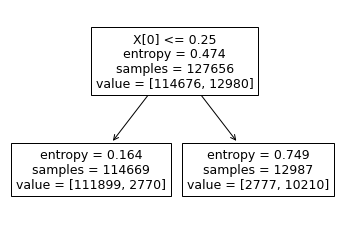

In [59]:
tree.plot_tree(tree_m)

Модель всего лишь каллибрует вероятности, выдаваемые логистической регрессией. Тем не менее, выдаёт лучший результат, значит длину сообщения можно убрать.

In [62]:
features_train_extra = np.delete(features_train_extra, 1, axis=1)

In [63]:
tree_m.fit(features_train_extra, target_train_full)
prediction = tree_model.predict(features_test_extra)
f1_score(target_test,prediction)

0.7873967574181707

### Глупая модель

In [44]:
dummy = DummyClassifier(strategy='stratified')
dummy.fit(features_train,target_train)
prediction = dummy.predict(features_test)
f1_score(target_test,prediction)

0.10607462226333642

Ожидаемый результат.

## Выводы

Данный были подготовлены, очищены, лемматизированы, векторизированы, на них были обучены логистическая регрессия и CatBoost, удовлетворительный результат дала логистическая регрессия, которая была улучшена моделью древа решений типа "пень". За кулисами была опробована обработка на предобученной нейросети DistilBERT, которая в связке с логистической регрессией и при располагаемых ресурсах тоже не дала удовлетворительного результата. 